In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [2]:
# Create units for model
m = UNITS.meter
s = UNITS.seconds
kg = UNITS.kilogram
degree = UNITS.degree
N = UNITS.newton
K = UNITS.kelvin
C = UNITS.celsius
F = UNITS.fahrenheit
W = UNITS.watt
J = UNITS.joule
Pa = UNITS.pascal

<Unit('pascal')>

In [3]:
T_0 =  385 * K # 288 inital (326.84 neutral buoyant)
x_0 = 0 *m
y_0 = 0 * m
vx_0 = 0 * (m/s)
vy_0 = 0 * (m/s)

init = State(T=T_0,
            x=x_0,
            y=y_0,
            vx = vx_0,
            vy=vy_0)

,values
T,385 kelvin
x,0 meter
y,0 meter
vx,0 meter / second
vy,0 meter / second


In [4]:
system1 = System(init = init,
                g = -9.8 * m/s**2,
                mass = 613 * kg,   #210 F air (805 kg) + human (105 lb) + hot air balloon mass # 925.656 kg w air. MASS TOO HEAVY
                diameter = 15 * m,     #diameter of the hopper hot air balloon
                volume = 2200 * m**3,  #volume of hopper
                p_air = 1.2 * kg/m**3, #density (rho) of dry air
                coeff_d = 0.47,        #coefficient of drag
                area = 706.8 * m**2,   #cross sectional area of ballon for drag and wind force 
                gas_constant = 287.05 * J/(kg * K), #gas constant for pressure equation
                air_pressure = 101325 * Pa,       #constant air pressure 
                wind_speed = 4.4 , #wind speed for cross wind
                t_0 = 0 *s,             #start time of simulation
                t_end = 500 * s)        #end time of simulation

,values
init,T 385 kelvin x 0 meter ...
g,-9.8 meter / second ** 2
mass,613 kilogram
diameter,15 meter
volume,2200 meter ** 3
p_air,1.2 kilogram / meter ** 3
coeff_d,0.47
area,706.8 meter ** 2
gas_constant,287.05 joule / kelvin / kilogram
air_pressure,101325 pascal


In [5]:
#def cool_func(state, system):
    
    #T, x, y, vx, vy = state
    #unpack(system)
    #T = -.256 * K + T
    #return T

def heat_func(state, system):
    
    T, x, y, vx, vy = state
    unpack(system)

    T = 1 *K + T
    return T

In [6]:
#cool_func(init, system)

In [7]:
#heat_func(init,system)

In [8]:
def density_in(state, system):
    unpack(system1)
    T, x, y, vx, vy = state
    density_in = air_pressure / (gas_constant * T)
#     print(density_in.units)
    
    return density_in

In [9]:
density_in(init,system1)

<Quantity(0.9168500894681003, 'kilogram * pascal / joule')>

In [10]:
def buoyant_force(state, system):
    """Computes buoyant force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    T, x, y, vx, vy = state
    unpack(system1)
    
    d = Vector(0 * (m/s**2),-g)
    
    balloon_density = density_in(state,system)
#     print(p_air.units, balloon_density.units)
    f_b_mag = volume * (p_air - balloon_density) * d.mag
   # print(f_b_mag)
    direction = d.hat()
    f_b = direction * f_b_mag
    return f_b

In [11]:
buoyant_force(init, system1)

<Quantity([   0.         6104.71207107], 'kilogram * meter / second ** 2')>

In [12]:
def drag_force(state, system):
    """Computes drag force in the opposite direction of `V`.
    
    V: velocity vector
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    T, x, y, vx, vy = state
    unpack(system1)
    V = Vector(vx, vy)
    mag = p_air * V.mag**2 * coeff_d * area / 2
    direction = -V.hat()
    f_drag = direction * mag
    return f_drag

In [13]:
drag_force(init,system1)

<Quantity([0. 0.], 'kilogram * meter / second ** 2')>

In [14]:
def wind_force(state, system):
    """Computes force of cross wind based on wind speed
    
    """
    
    T, x, y, vx, vy = state
    unpack(system1)
    direction = Vector(1,0)
    wind_pressure = (wind_speed**2) * 0.613 * (N/(m**2))
    mag = area * coeff_d * 0.613 * wind_pressure
    wind_force = direction * mag
    
    return wind_force

In [15]:
wind_force(init,system1)

<Quantity([2416.6886409    0.       ], 'newton')>

In [16]:
def slope_func_heat(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    T, x, y, vx, vy = state
    unpack(system1)
    
    
    dTdt = 1
    V = Vector(vx, vy)  
    a_buoyant = buoyant_force(state, system) / mass
    a_wind = wind_force(state,system) / mass
    a_drag = drag_force(state, system) / mass
    a_grav = Vector(0, g)
    
    a = a_grav + a_drag + a_wind + a_buoyant
    #print(a_buoyant)
    #print(a_drag)
    #print(a_grav)
    #print(a_wind)
    #print(a)
    
    return dTdt, vx, vy, a.x, a.y

In [17]:
slope_func_heat(init, 0,system1)

(1,
 <Quantity(0, 'meter / second')>,
 <Quantity(0, 'meter / second')>,
 <Quantity(3.94239582528, 'meter / second ** 2')>,
 <Quantity(0.1587472611219507, 'meter / second ** 2')>)

In [18]:
ts = linrange(system1.t_0/s, system1.t_end/s, 1)
results_heat, details = run_ode_solver(system1, slope_func_heat, t_eval = ts)

In [19]:
results_heat.tail()

,T,x,y,vx,vy
495.0,880.0,1033.878822,2747.938250,1.599397,7.420535
496.0,881.0,1035.477471,2755.358568,1.596212,7.412246
497.0,882.0,1037.074543,2762.778048,1.597523,7.424816
498.0,883.0,1038.671675,2770.204276,1.595246,7.420687
499.0,884.0,1040.267619,2777.631435,1.595553,7.428564


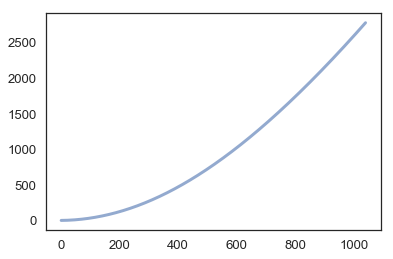

In [20]:
plot(results_heat.x, results_heat.y)

init2 = State(T=get_last_value(results_heat.T),
            x=get_last_value(results_heat.x),
            y=get_last_value(results_heat.y),
            vx = get_last_value(results_heat.vx),
            vy=get_last_value(results_heat.vy))

In [21]:
t_0 = get_last_label(results_heat) * s
T, x, y, vx, vy = get_last_value(results_heat)
init2 = State(T=T*K, x=x*m, y=y*m, vx=vx*m/s, vy=vy*m/s)
t_0

<Quantity(499.0, 'second')>

In [22]:
system2 = System(system1, t_0=t_0, init=init2, t_end= 5000 *s)

,values
init,T 883.9999999999889 kelvin x ...
g,-9.8 meter / second ** 2
mass,613 kilogram
diameter,15 meter
volume,2200 meter ** 3
p_air,1.2 kilogram / meter ** 3
coeff_d,0.47
area,706.8 meter ** 2
gas_constant,287.05 joule / kelvin / kilogram
air_pressure,101325 pascal


In [23]:
def slope_func_cool(state, t, system):
    """Computes derivatives of the state variables when ballon is cooling.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (dTdt, vx, vy, ax, ay)
    """
    T, x, y, vx, vy = state
    unpack(system2)
    
    
    dTdt = -0.256
    V = Vector(vx, vy)  
    a_buoyant = buoyant_force(state, system) / mass
    a_wind = wind_force(state,system) / mass
    a_drag = drag_force(state, system) / mass
    a_grav = Vector(0, g)
    
    a = a_grav + a_drag + a_wind + a_buoyant
    #print(a_buoyant)
    #print(a_drag)
    #print(a_grav)
    #print(a_wind)
    #print(a)
    
    return dTdt, vx, vy, a.x, a.y

In [24]:
slope_func_cool(init, 0, system2)

(-0.256,
 <Quantity(0, 'meter / second')>,
 <Quantity(0, 'meter / second')>,
 <Quantity(3.94239582528, 'meter / second ** 2')>,
 <Quantity(0.1587472611219507, 'meter / second ** 2')>)

In [25]:
def event_func(state, t, system):
    T, x, y, vx, vy = state
    return y

In [26]:
ts = linrange(system2.t_0/s, system2.t_end/s, 1)
results_cool, details = run_ode_solver(system2, slope_func_cool, t_eval = ts, events=event_func)
results_cool

,T,x,y,vx,vy
499.0,884.000,1040.267619,2777.631435,1.595553,7.428564
500.0,883.744,1041.863220,2785.061459,1.595281,7.428652
501.0,883.488,1043.458824,2792.490973,1.595269,7.427158
502.0,883.232,1045.054320,2799.918400,1.596605,7.431785
503.0,882.976,1046.650664,2807.348150,1.594576,7.420697
504.0,882.720,1048.246171,2814.772352,1.597546,7.432866
505.0,882.464,1049.843223,2822.202091,1.593710,7.413371
506.0,882.208,1051.439034,2829.624411,1.596844,7.426294
507.0,881.952,1053.035880,2837.049886,1.595685,7.419249
508.0,881.696,1054.632320,2844.471818,1.597378,7.425467


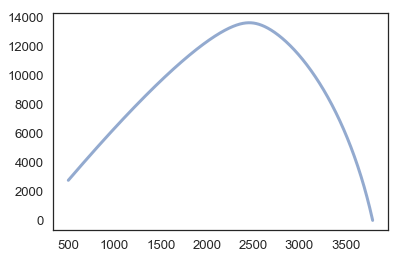

In [27]:
plot(results_cool.y)

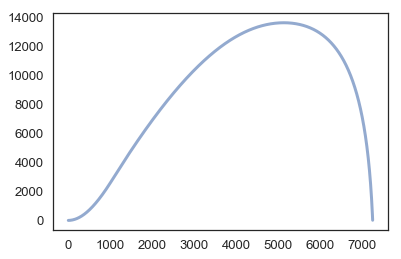

In [28]:
results = results_cool.combine_first(results_heat)
plot(results.x, results.y)

In [29]:
mass * g

<Quantity(-6007.400000000001, 'kilogram * meter / second ** 2')>

In [32]:
def burner_func(t):
    burner = int(((t+3)%6)/3)
    
    return burner

In [33]:
def dT_func(burner_func,t):
    
    burner = burner_func(t)
    T, x, y, vx, vy = state
    
    if burner == 1:
        dT = 1
        return dT 
    else:
        dT = -0.256
        return dT
    

In [34]:
x = linspace(0, 500, 101)
y1 = (burner_func(i) for i in x)

<generator object <genexpr> at 0x0000012644ACD5C8>

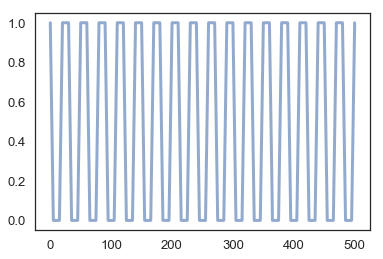

In [35]:
plot(x,y1)
